In [3]:
import sys
import pandas as pd


# import custom modules
sys.path.append('../../utils/')
import data_paths
import traffic_counts
from itertools import product
from pandas.tseries.offsets import YearEnd


In [4]:
from IPython.display import display

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [5]:
_counts = traffic_counts.TrafficCounts()
vehicle_share_counts = _counts.vehicle_shares.reset_index()
annual_cycles_counts = _counts.annual_cycles.reset_index()

In [19]:
# Creating a date range from 2019-01-01 to 2022-12-31
date_range = pd.date_range(start='2019-01-01', end='2022-12-31')

# Getting unique values of 'road_type' and 'vehicle_class'
unique_road_types = vehicle_share_counts['road_type'].unique()
unique_vehicle_classes = vehicle_share_counts['vehicle_class'].unique()

# Creating a template DataFrame with all combinations of 'road_type', 'vehicle_class', and 'date'
all_combinations = product(unique_road_types, unique_vehicle_classes, date_range)
template_df = pd.DataFrame(all_combinations, columns=['road_type', 'vehicle_class', 'date'])

# Converting 'date' in original DataFrame to datetime for merging
vehicle_share_counts['date'] = pd.to_datetime(vehicle_share_counts['date'])

# Merging the template DataFrame with the original DataFrame
merged_df = template_df.merge(vehicle_share_counts, on=['road_type', 'vehicle_class', 'date'], how='left', indicator=True)

# Identifying the missing entries where '_merge' is 'left_only'
missing_entries = merged_df[merged_df['_merge'] == 'left_only']


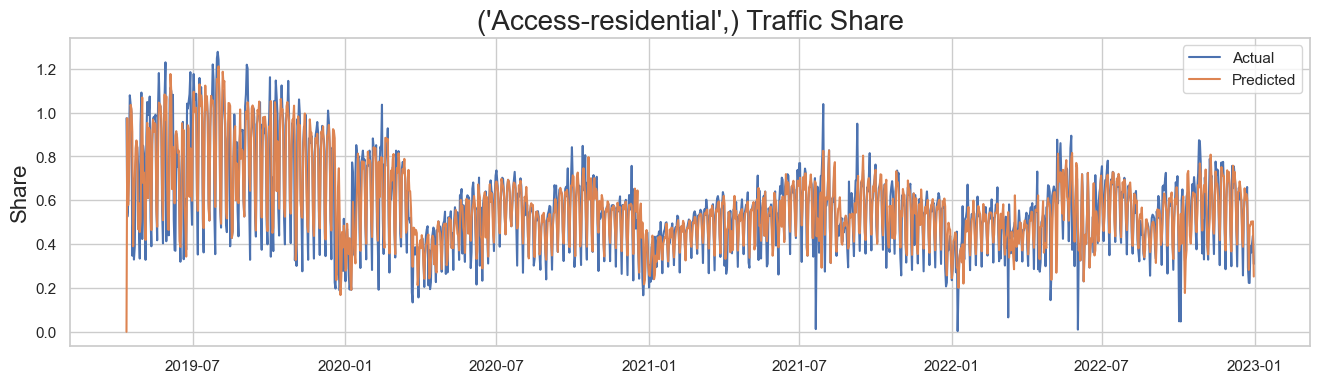

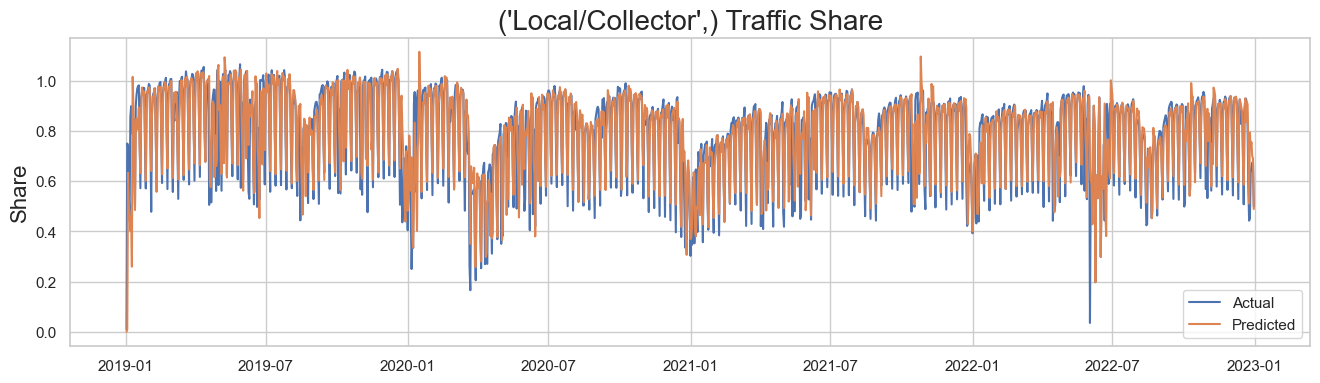

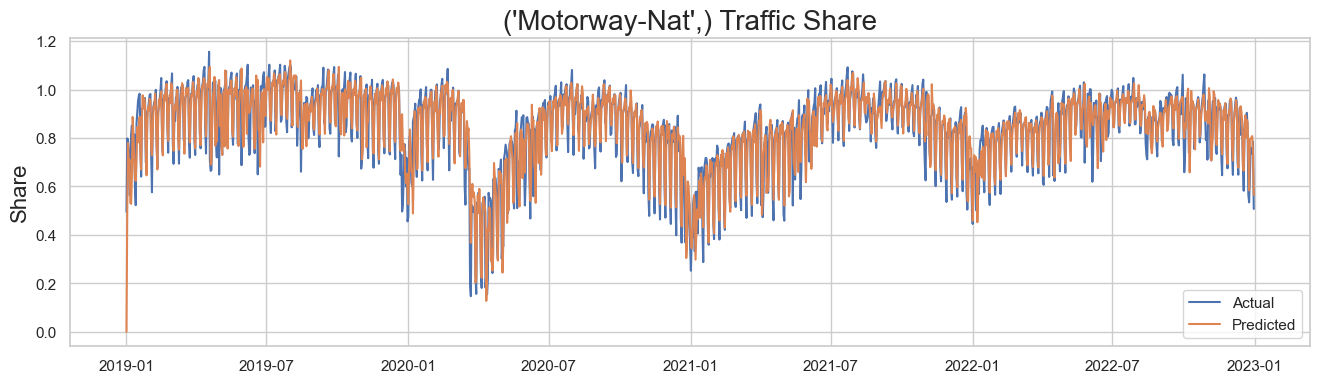

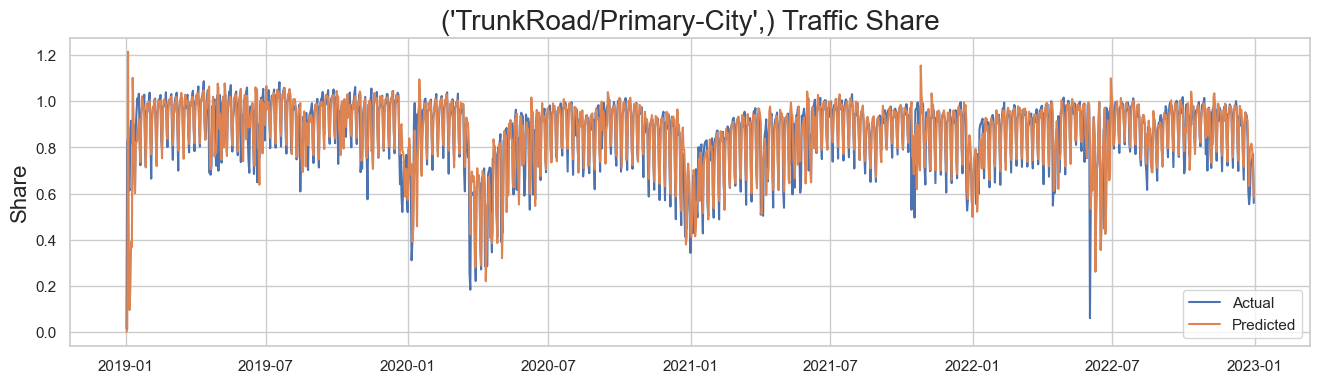

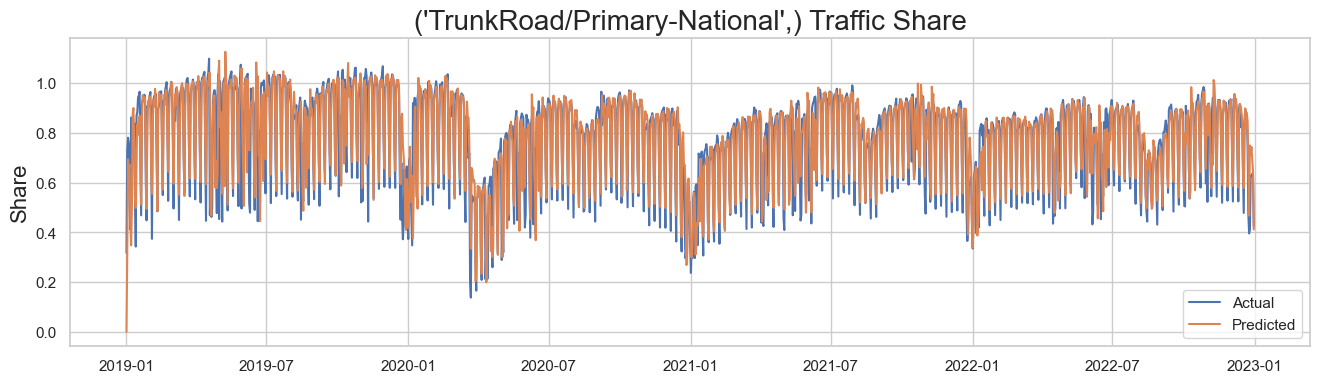

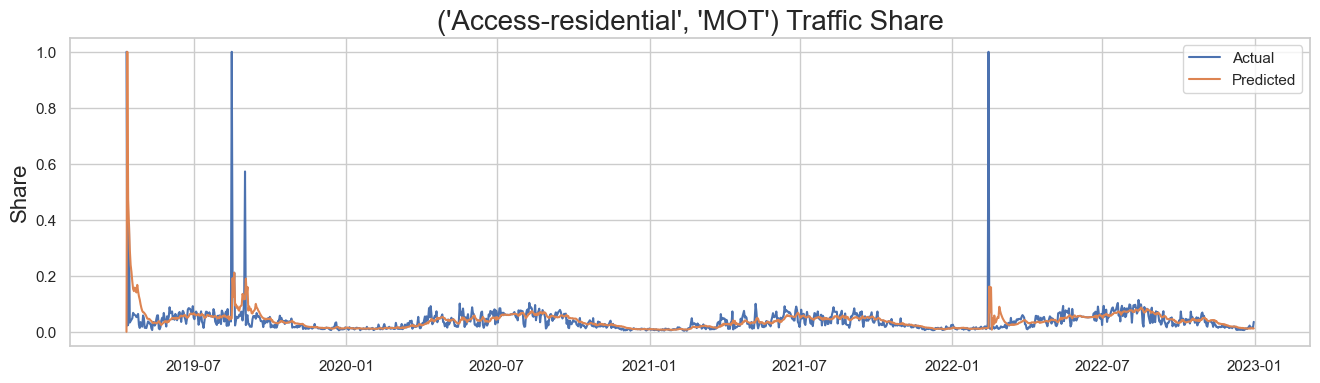

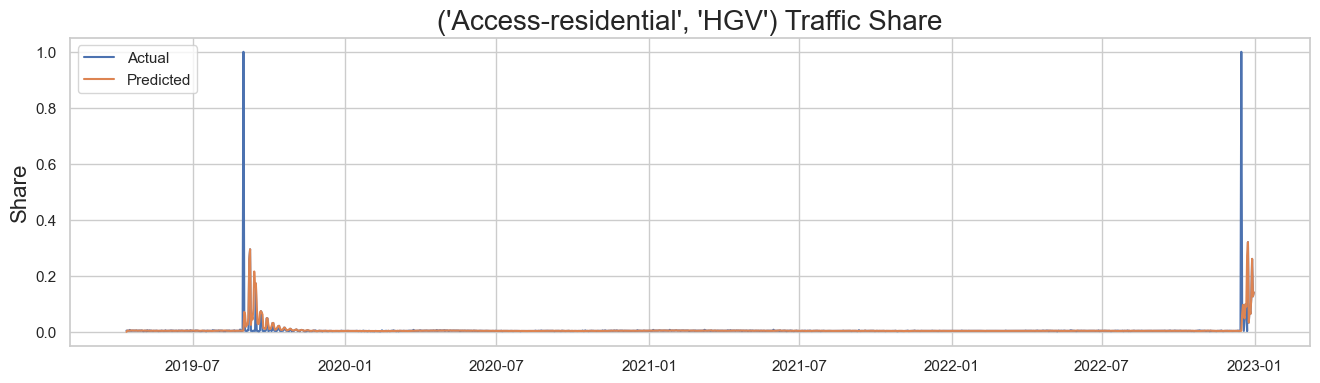

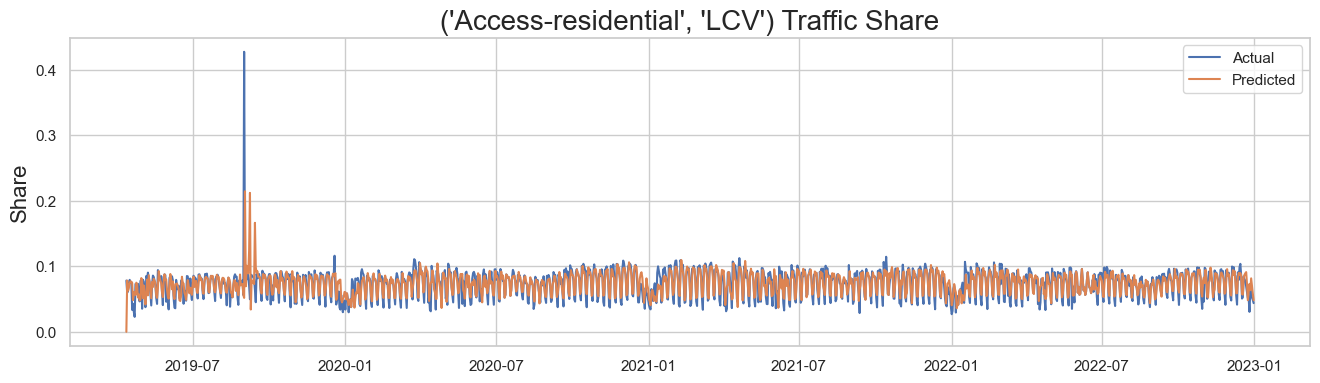

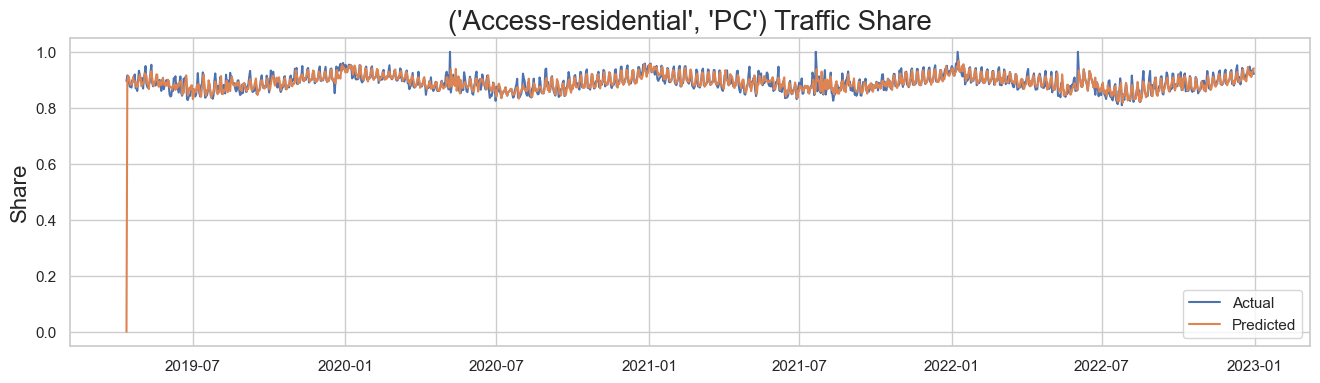

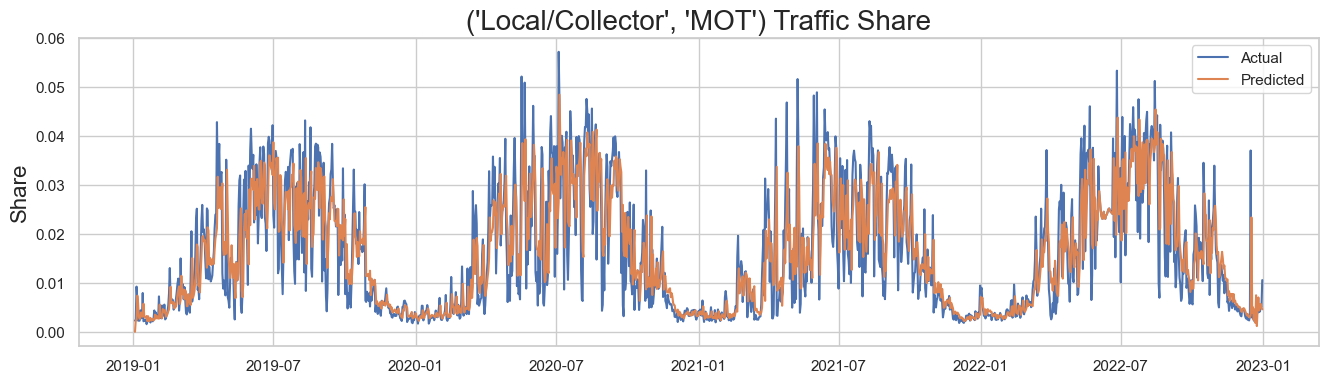

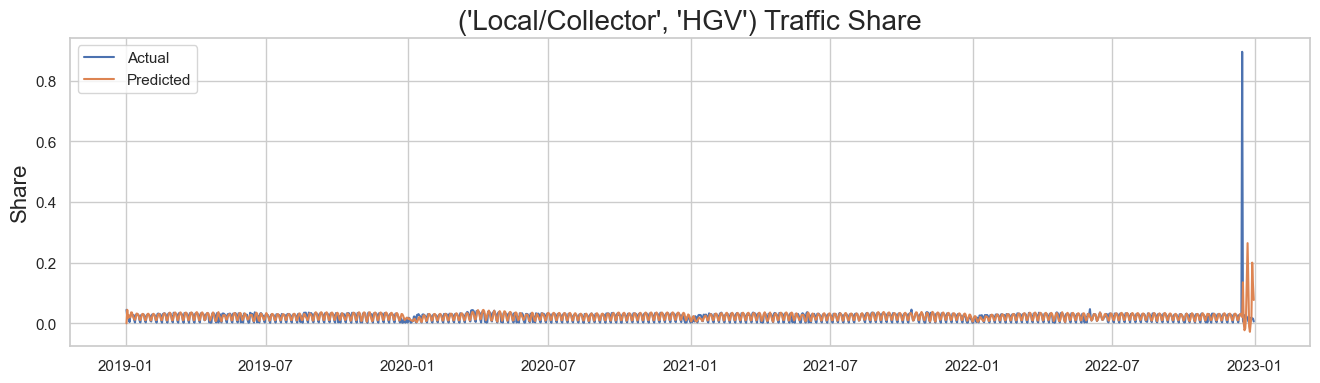

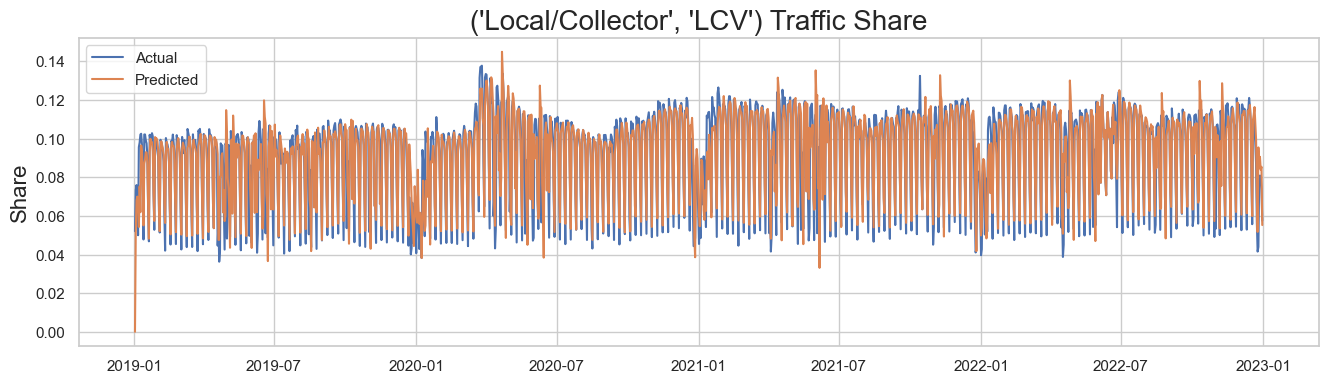

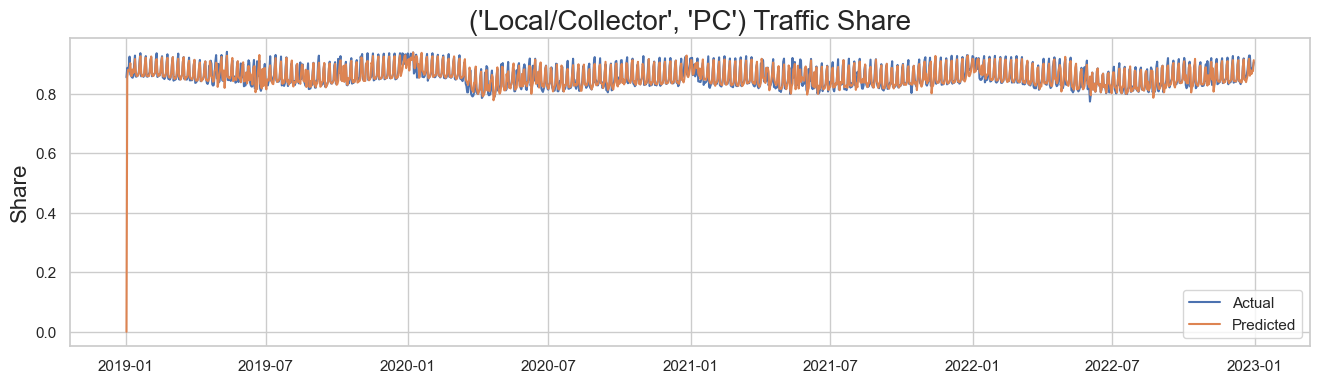

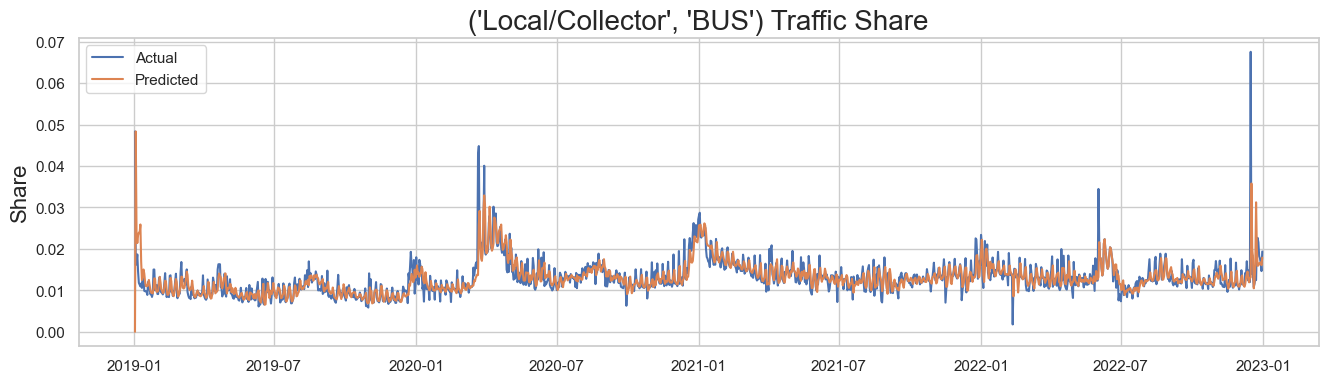

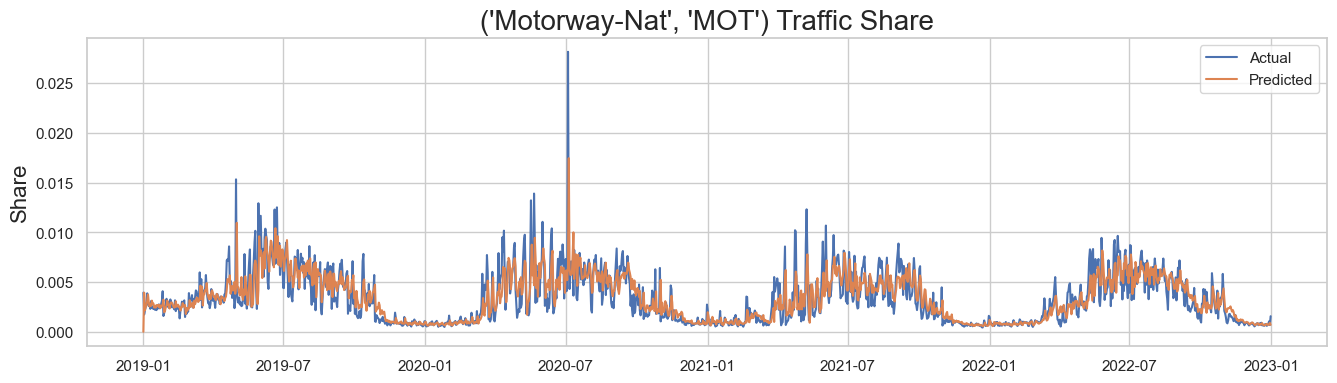

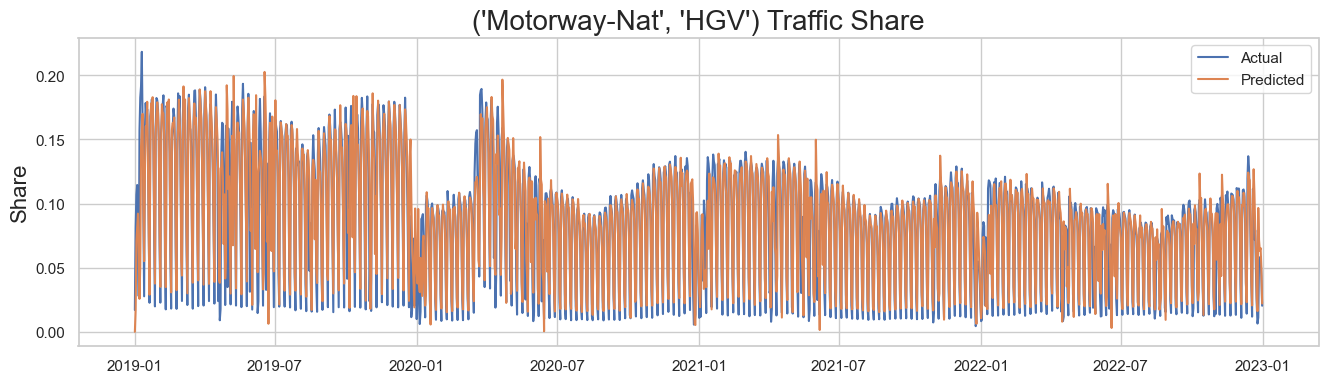

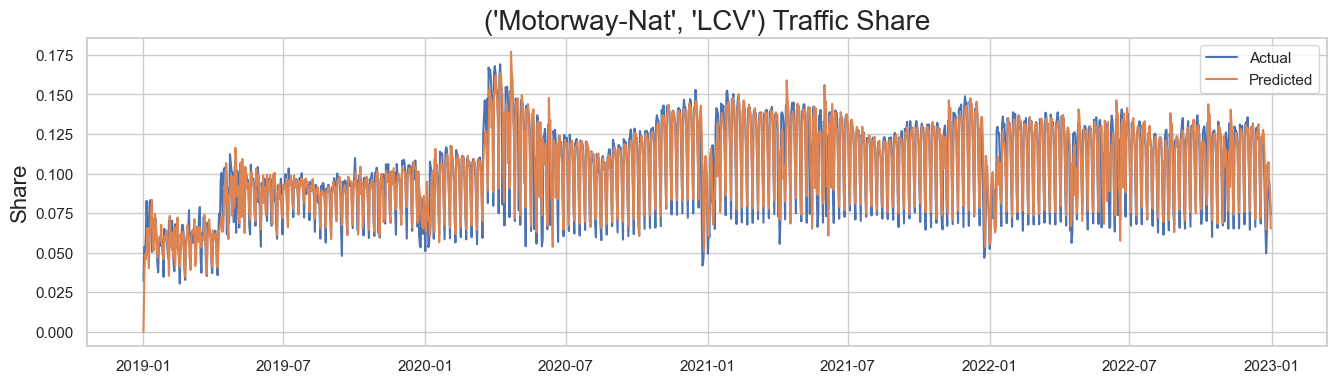

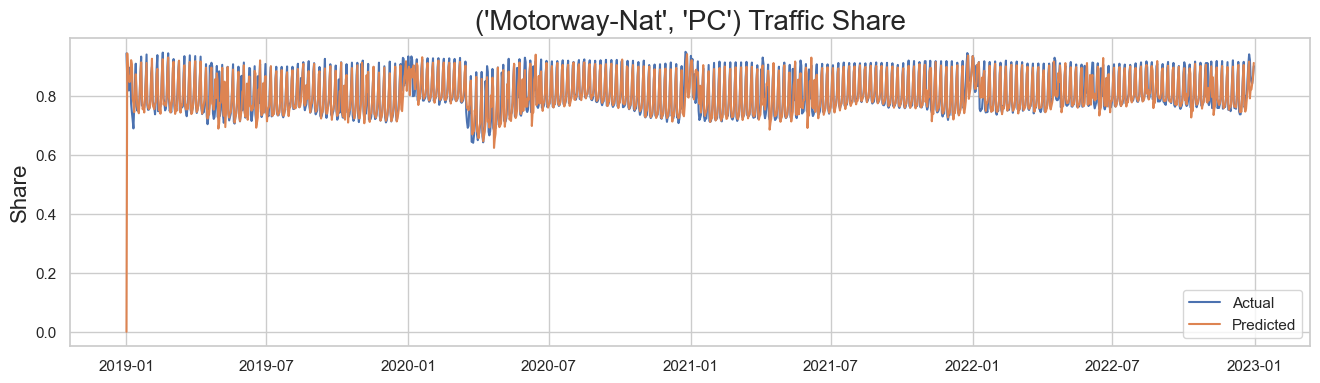

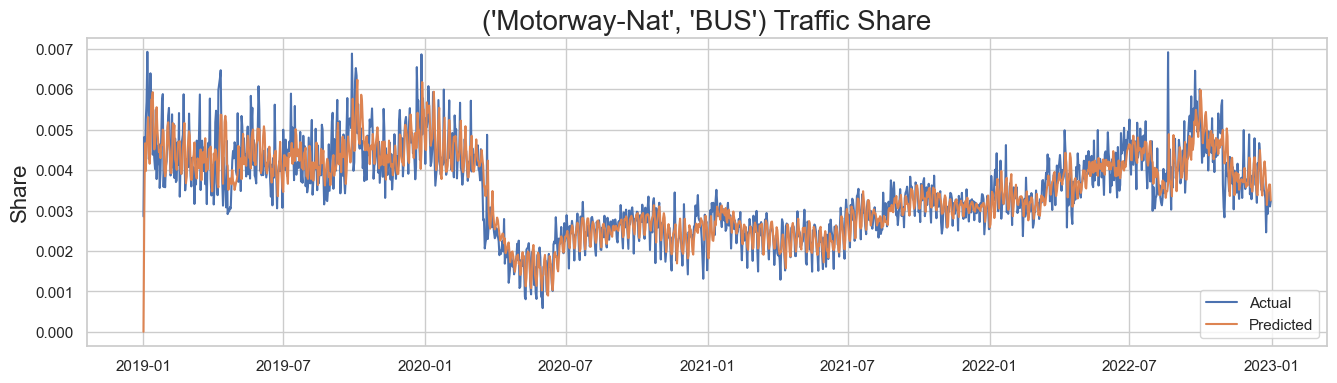

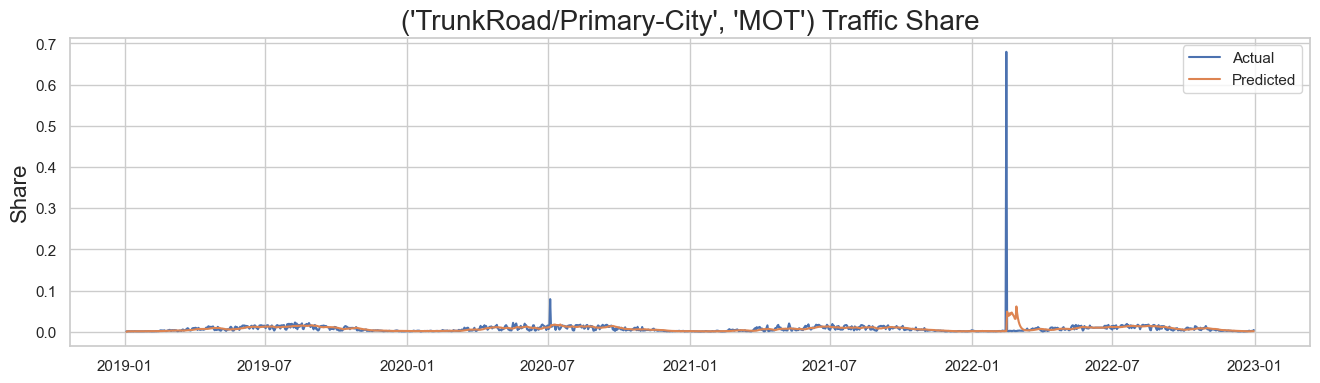

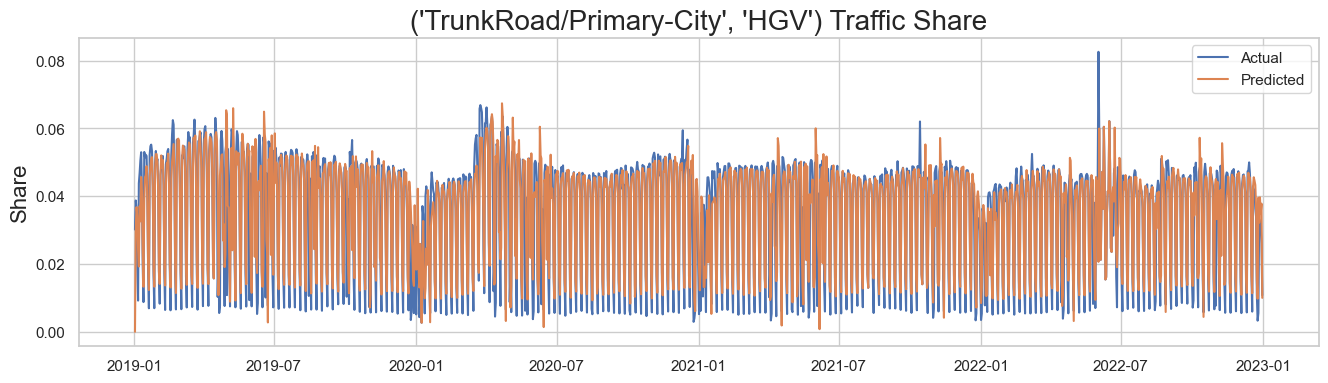

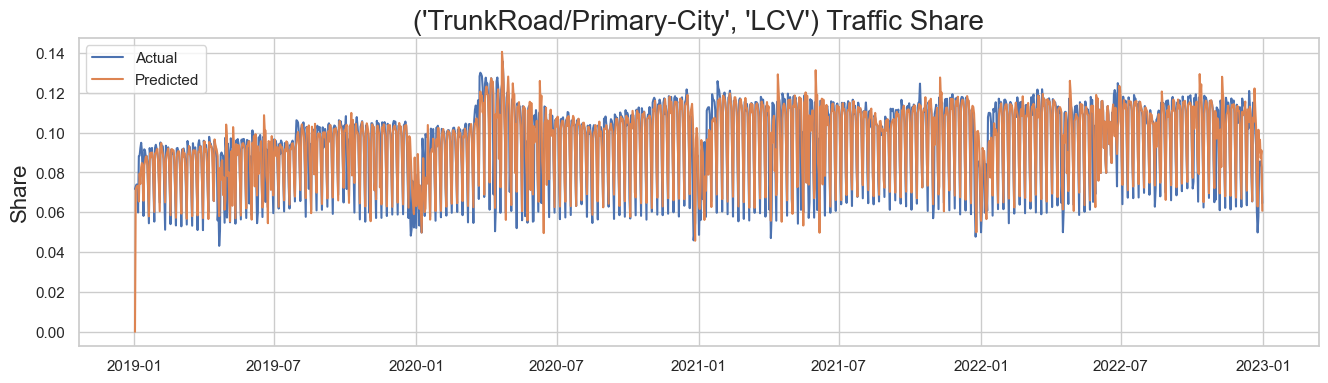

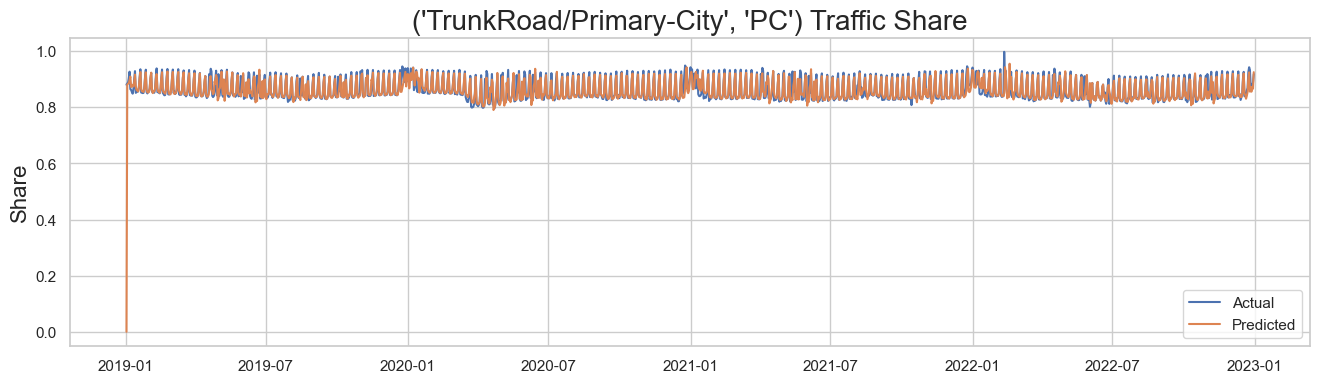

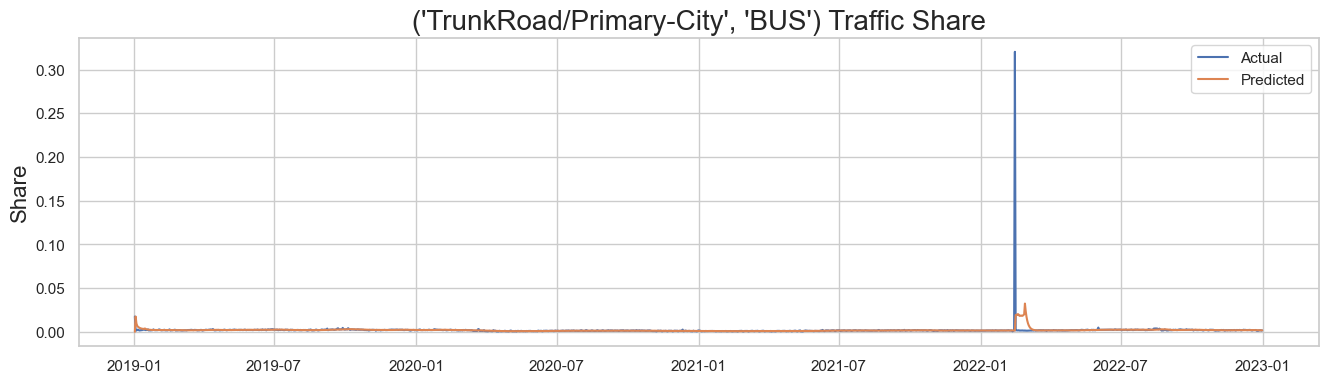

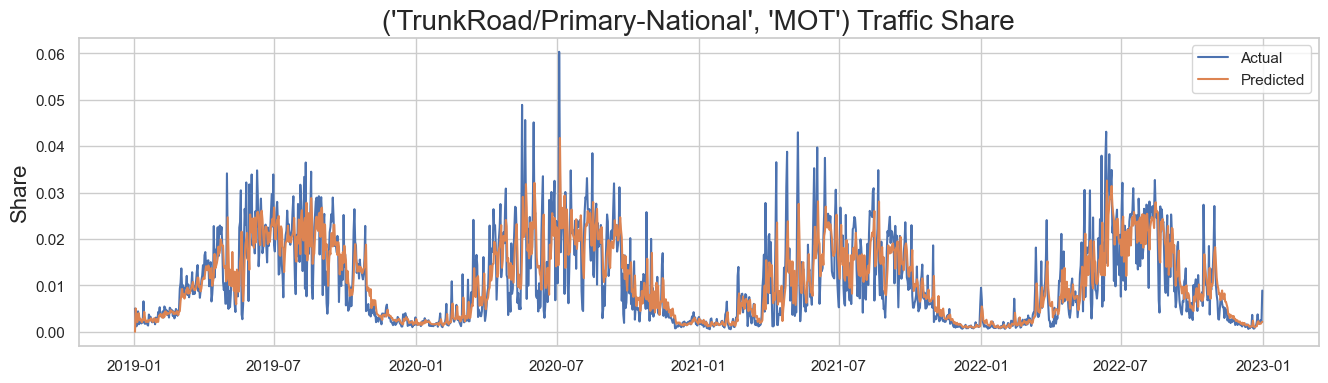

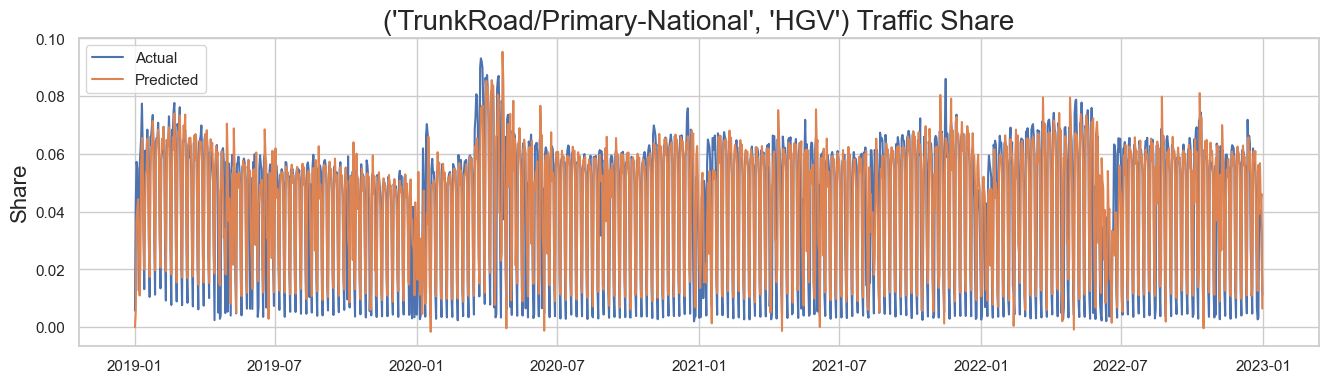

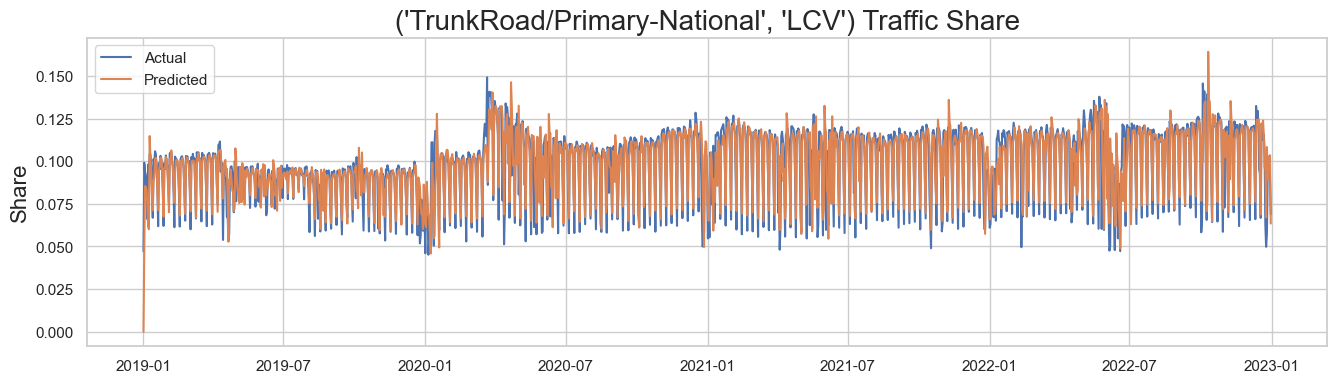

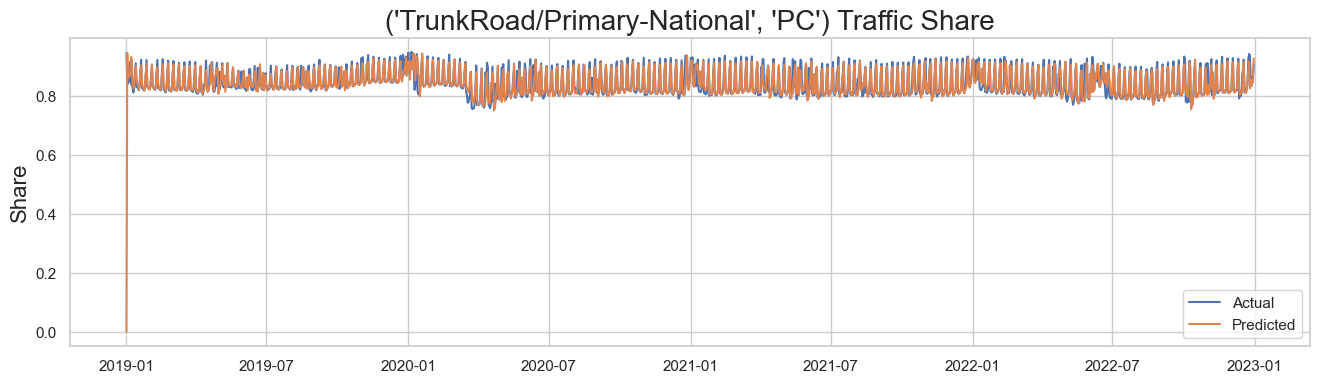

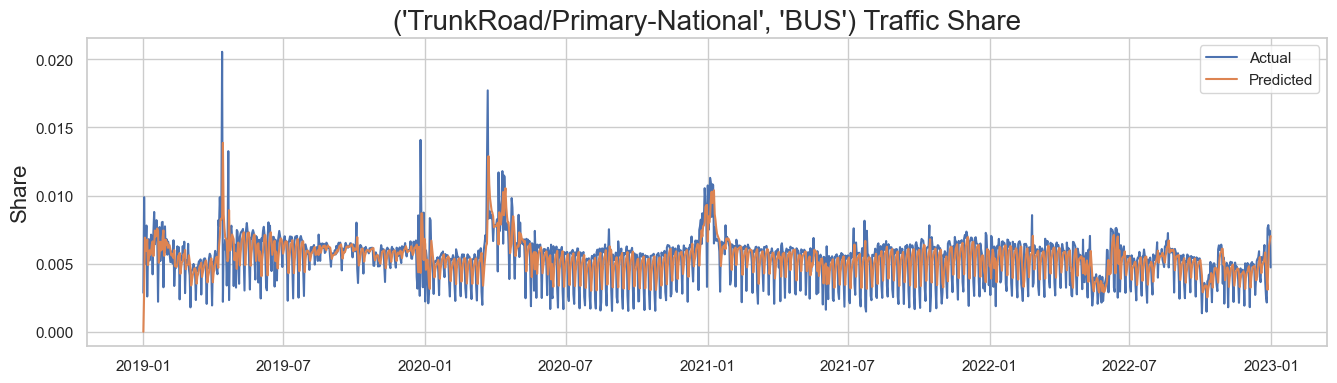

In [43]:
def fill_missing_values_with_arima(df, categories, value_column, arima_order=(12, 1, 1)):
    """
    Takes a DataFrame, creates a complete date range for each category combination,
    merges with the original dataset, and fills missing values using ARIMA.

    :param df: The DataFrame to process.
    :param categories: List of column names to define unique category combinations.
    :param value_column: Name of the column containing the values for ARIMA.
    :param arima_order: Order of the ARIMA model.
    """
    filled_df = pd.DataFrame()
    # Creating a date range from 2019-01-01 to 2022-12-31
    date_range = pd.date_range(start='2019-01-01', end='2022-12-31')

    # Create a template DataFrame with all combinations of categories and date
    unique_categories = [df[category].unique() for category in categories]
    all_combinations = product(*unique_categories, date_range)
    template_df = pd.DataFrame(all_combinations, columns=categories + ['date'])

    # Ensure 'date' column in df is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Merge the template DataFrame with the original DataFrame
    merged_df = template_df.merge(df, on=categories + ['date'], how='left', indicator=True)

    # Fill missing values with ARIMA for each category combination
    for category_values in product(*unique_categories):
        filter_condition = np.logical_and.reduce([merged_df[cat] == val for cat, val in zip(categories, category_values)])
        train_set = merged_df.loc[filter_condition, ['date', value_column]]
        first_non_nan = train_set[value_column].first_valid_index()

        if first_non_nan is not None:
            train_set = train_set.loc[first_non_nan:]
            train_set.set_index('date', inplace=True)
            train_set = train_set.asfreq(pd.infer_freq(train_set.index))

            arima = ARIMA(train_set[value_column], order=arima_order)
            predictions = arima.fit().predict()

            train_set[value_column][train_set[value_column].isna()] = predictions[train_set[value_column].isna()]
            filled_df = pd.concat([filled_df, pd.DataFrame(train_set)], ignore_index=True)

            plt.figure(figsize=(16, 4))
            plt.plot(train_set, label="Actual")
            plt.plot(predictions, label="Predicted")
            plt.title(f"{category_values} Traffic Share", fontsize=20)
            plt.ylabel('Share', fontsize=16)
            plt.legend()
            plt.show()

    return filled_df

# Example Usage
date_range = pd.date_range(start='2019-01-01', end='2022-12-31')

# For annual_cycle_counts
cycle_categories = ['road_type']  # Modify as per your dataset columns
cycle_value_column = 'daily_value'  # Modify as per your dataset
annual_cycles_counts_filled = fill_missing_values_with_arima(annual_cycles_counts, cycle_categories, cycle_value_column)

# Assume vehicle_share_counts and annual_cycle_counts are already loaded as DataFrames
vehicle_categories = ['road_type', 'vehicle_class']
vehicle_value_column = 0
vehicle_share_counts_filled = fill_missing_values_with_arima(vehicle_share_counts, vehicle_categories, vehicle_value_column)


Access-residential:   MOT
Access-residential:   HGV
Access-residential:   LCV
Access-residential:   PC
Access-residential:   BUS
Local/Collector:   MOT
Local/Collector:   HGV
Local/Collector:   LCV
Local/Collector:   PC
Local/Collector:   BUS
Motorway-Nat:   MOT
Motorway-Nat:   HGV
Motorway-Nat:   LCV
Motorway-Nat:   PC
Motorway-Nat:   BUS
TrunkRoad/Primary-City:   MOT
TrunkRoad/Primary-City:   HGV
TrunkRoad/Primary-City:   LCV
TrunkRoad/Primary-City:   PC
TrunkRoad/Primary-City:   BUS
TrunkRoad/Primary-National:   MOT
TrunkRoad/Primary-National:   HGV
TrunkRoad/Primary-National:   LCV
TrunkRoad/Primary-National:   PC
TrunkRoad/Primary-National:   BUS


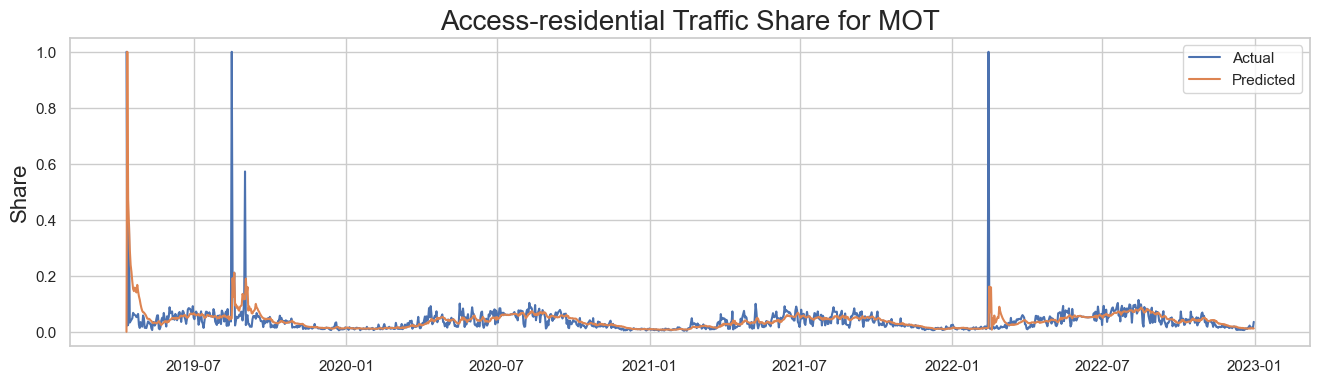

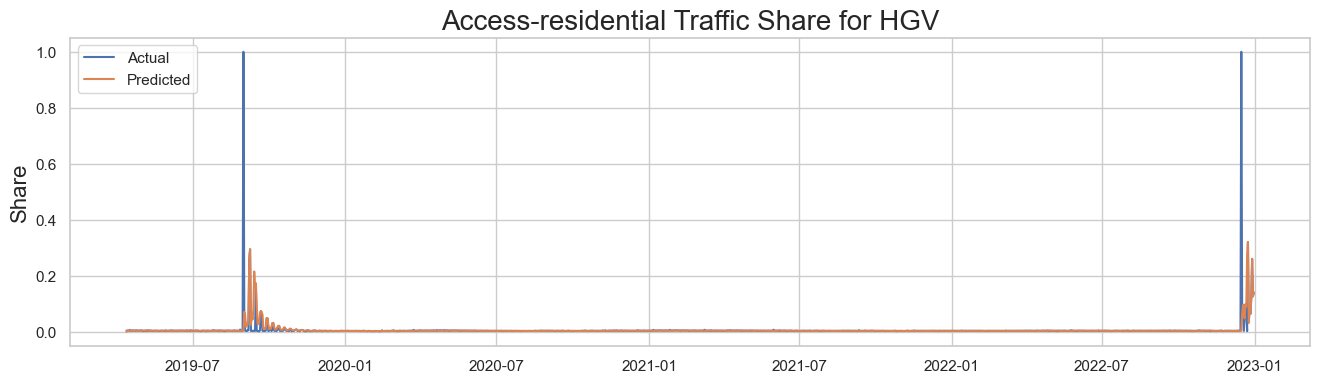

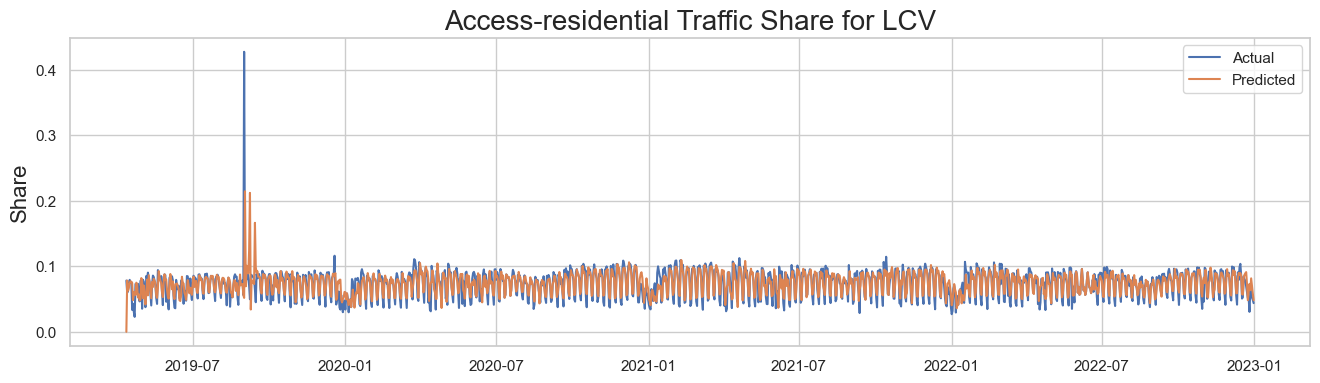

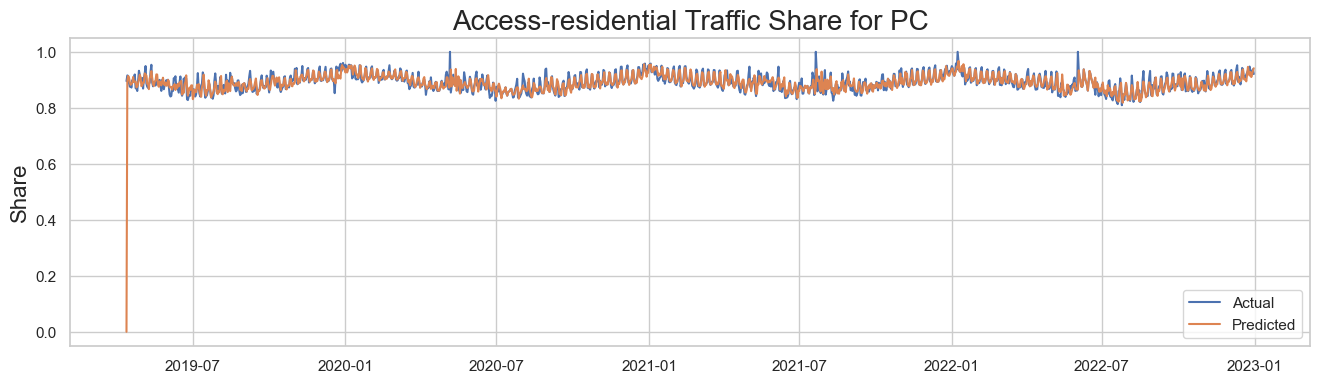

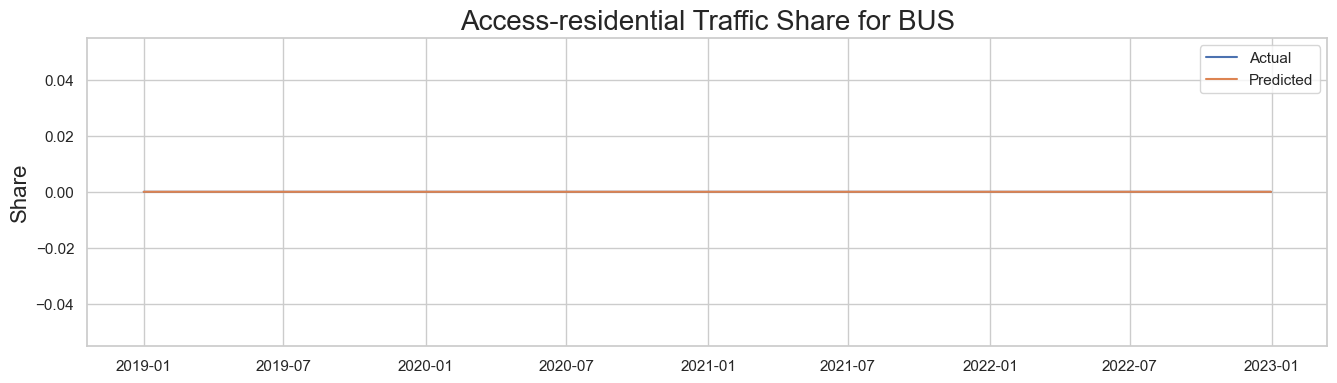

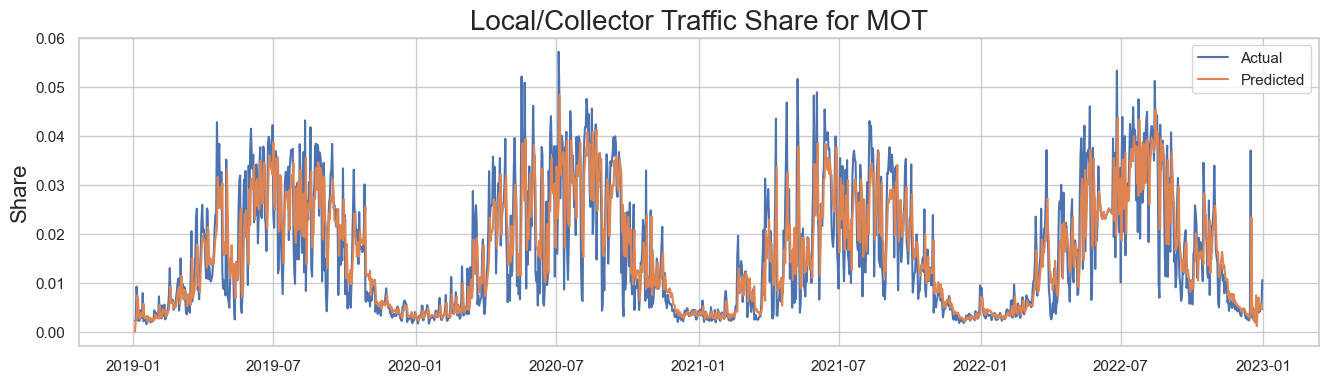

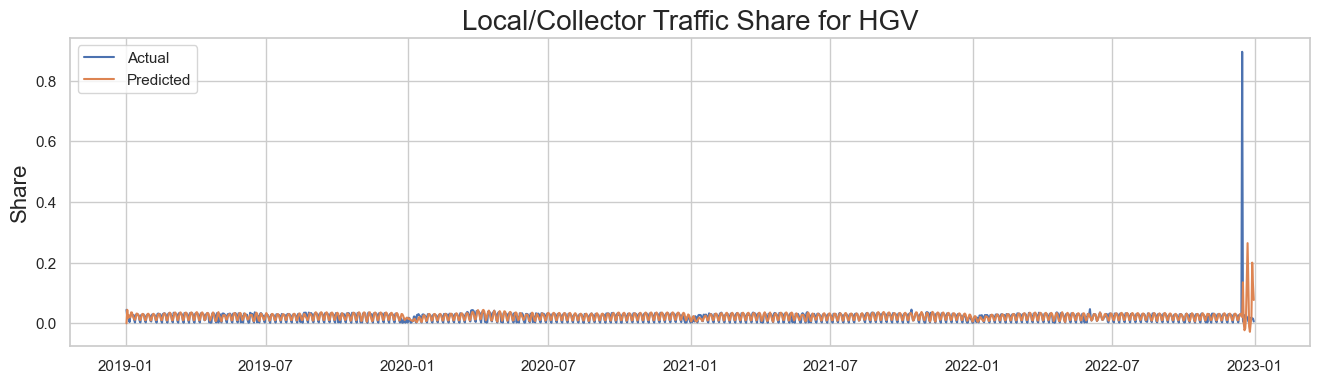

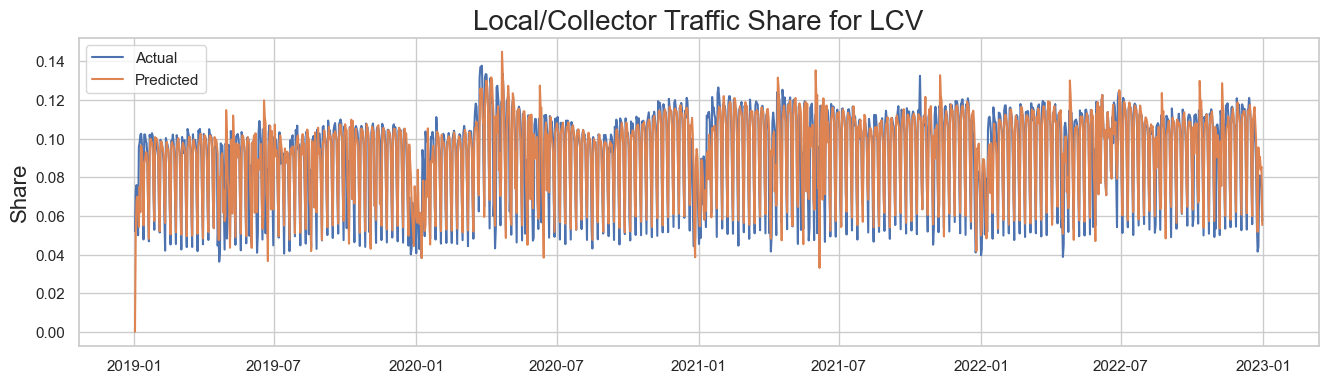

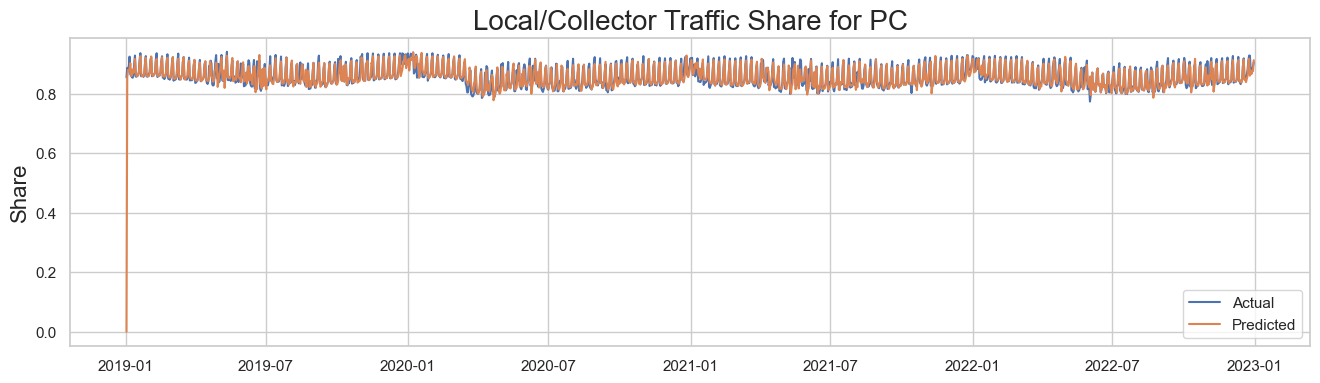

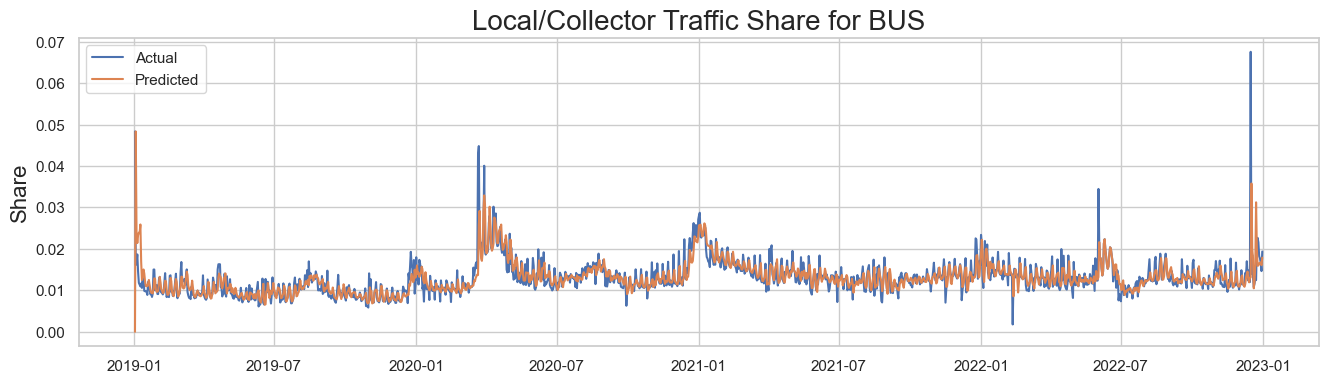

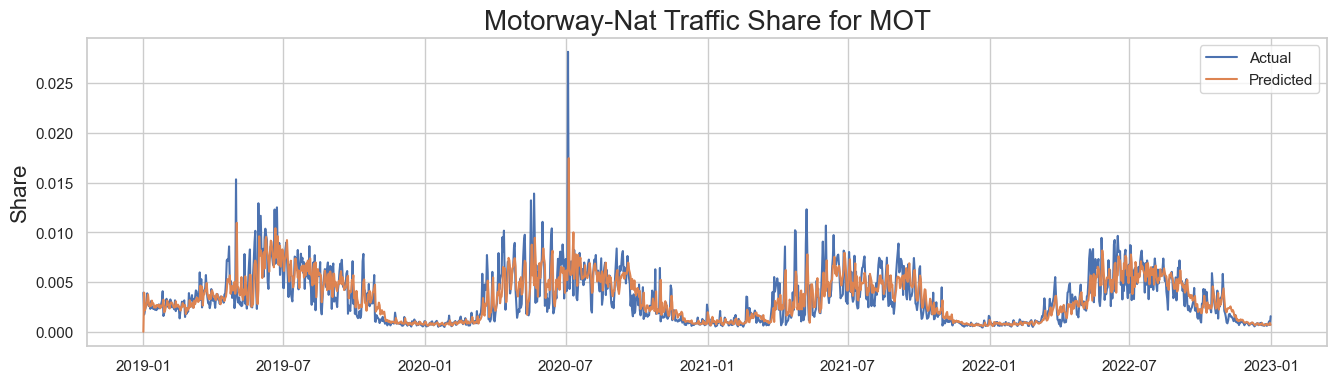

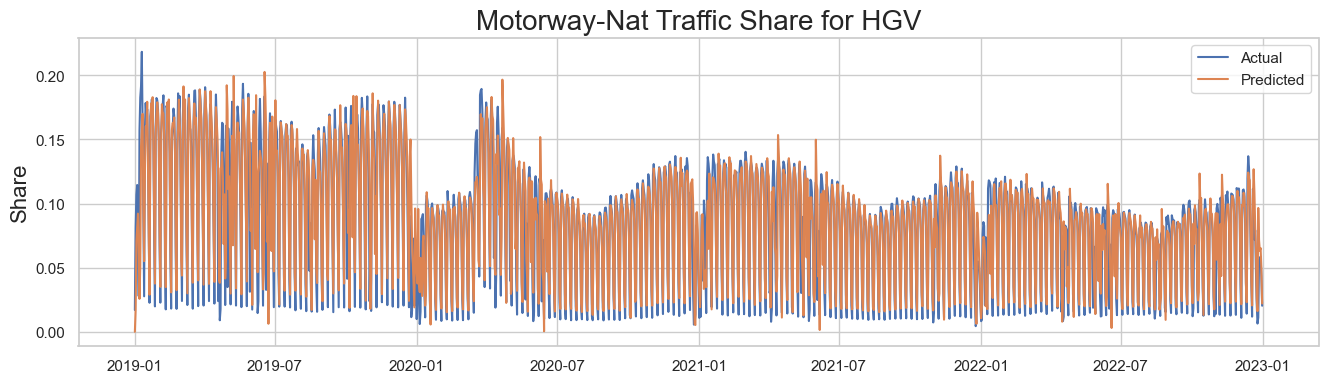

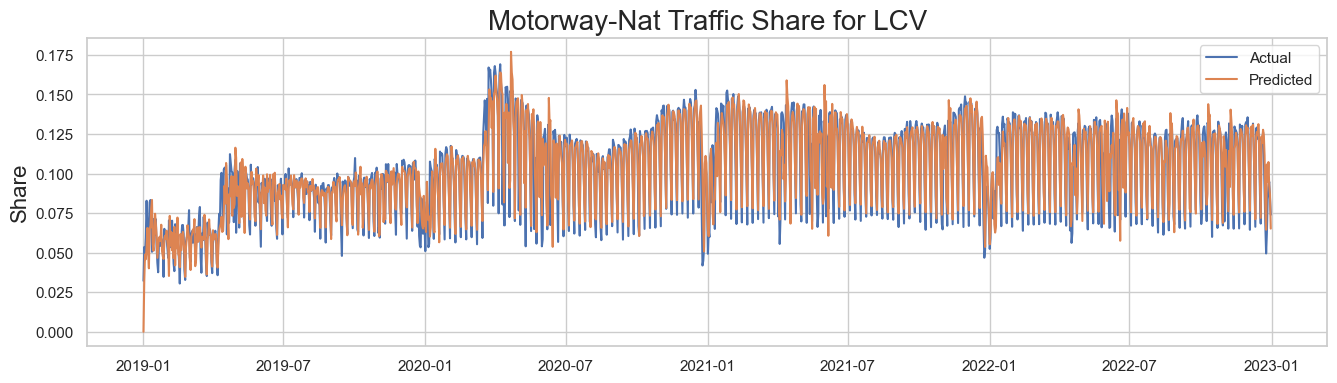

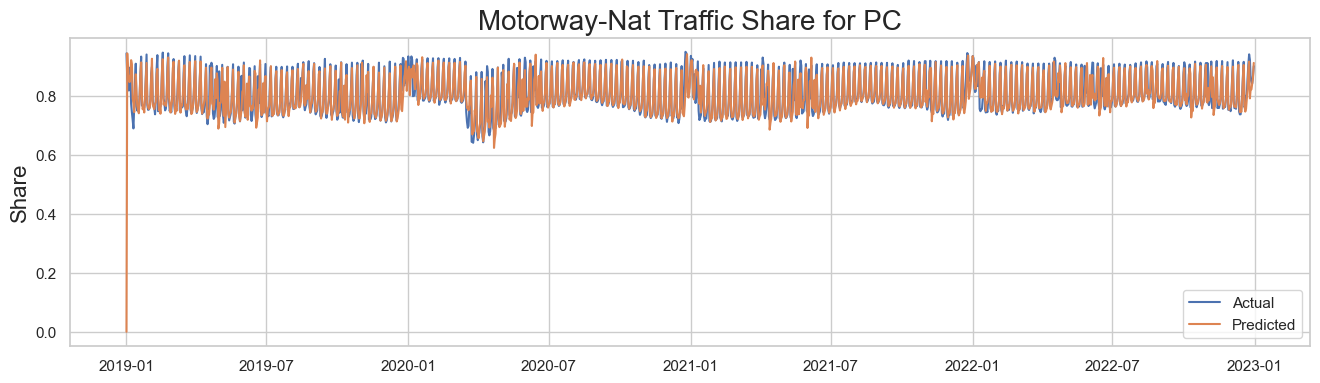

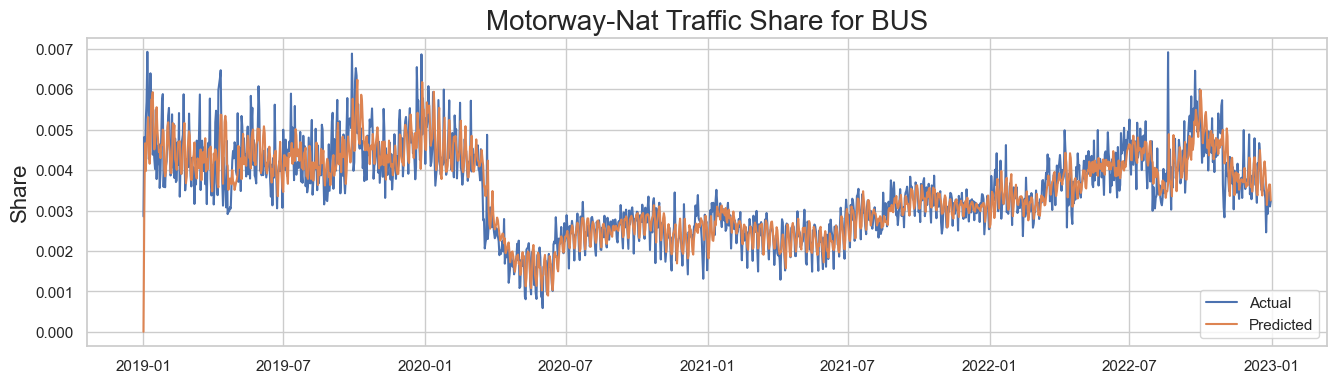

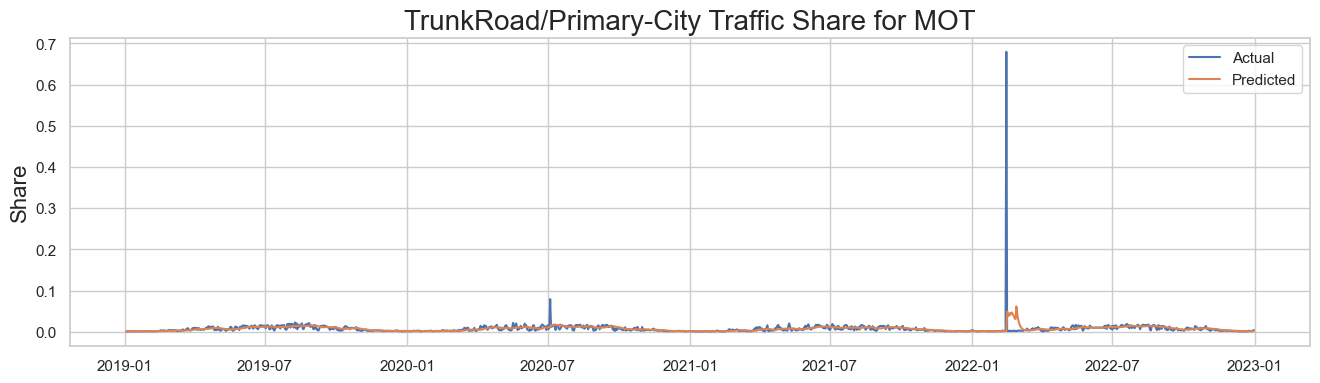

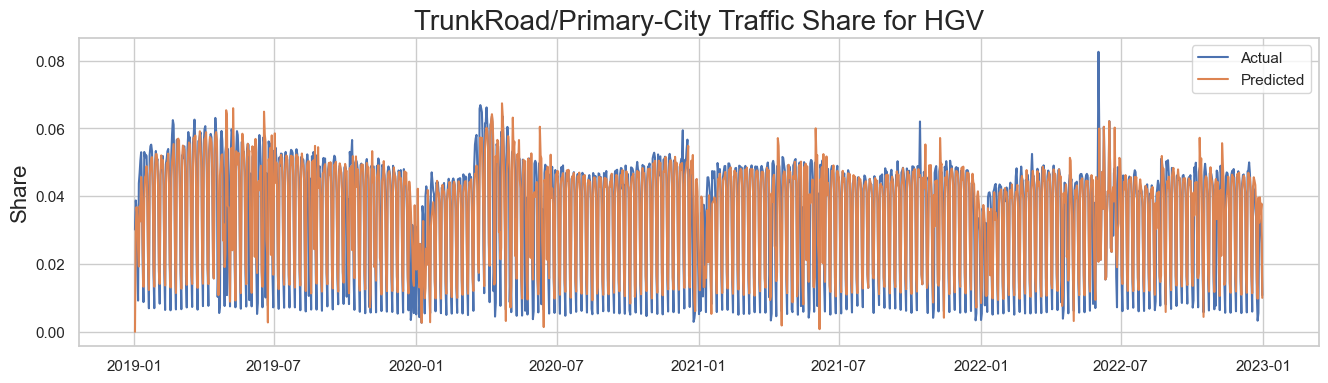

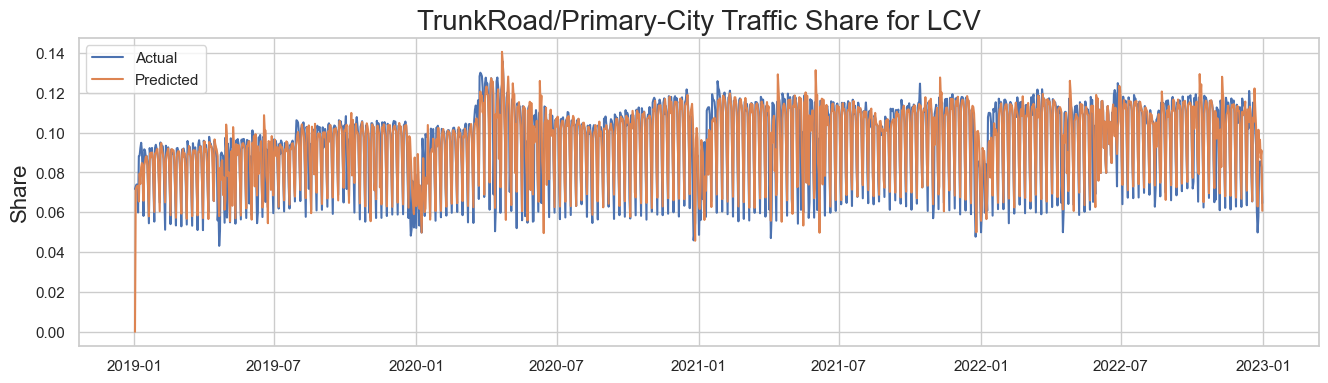

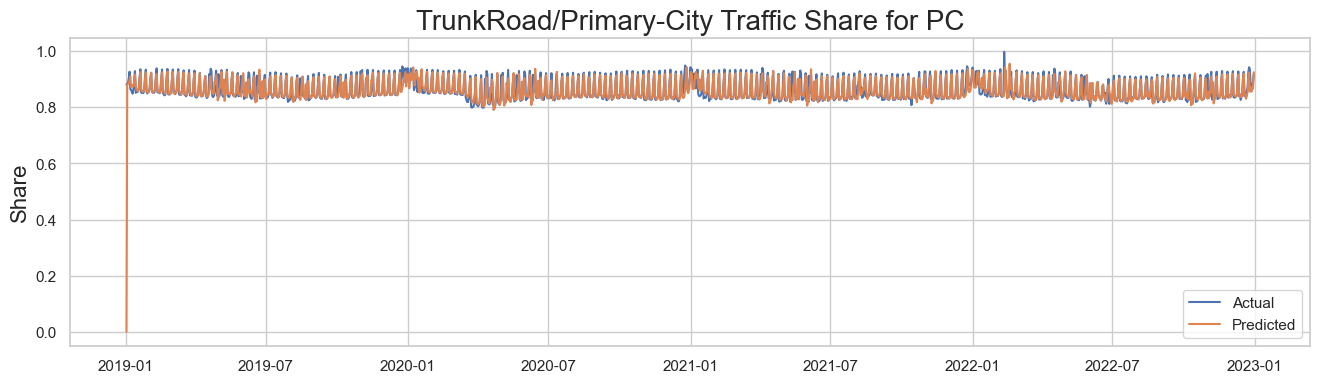

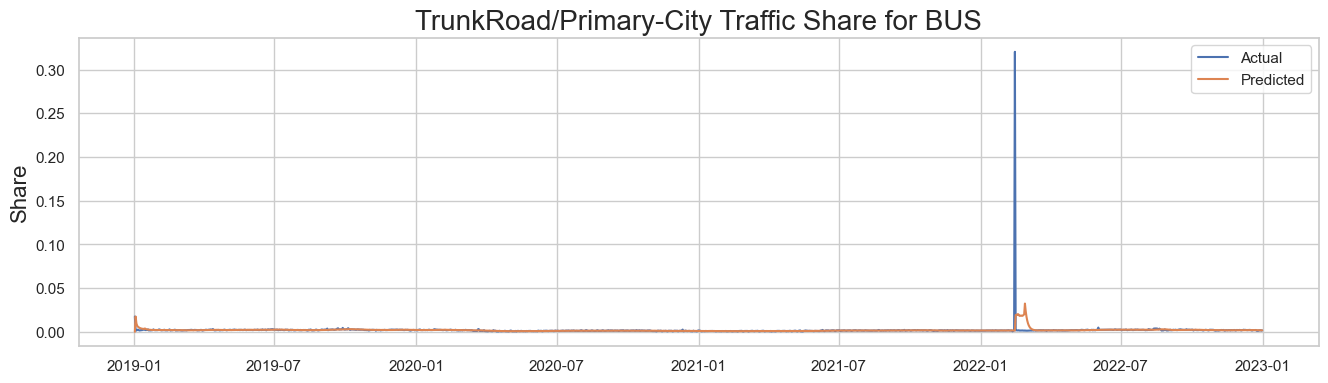

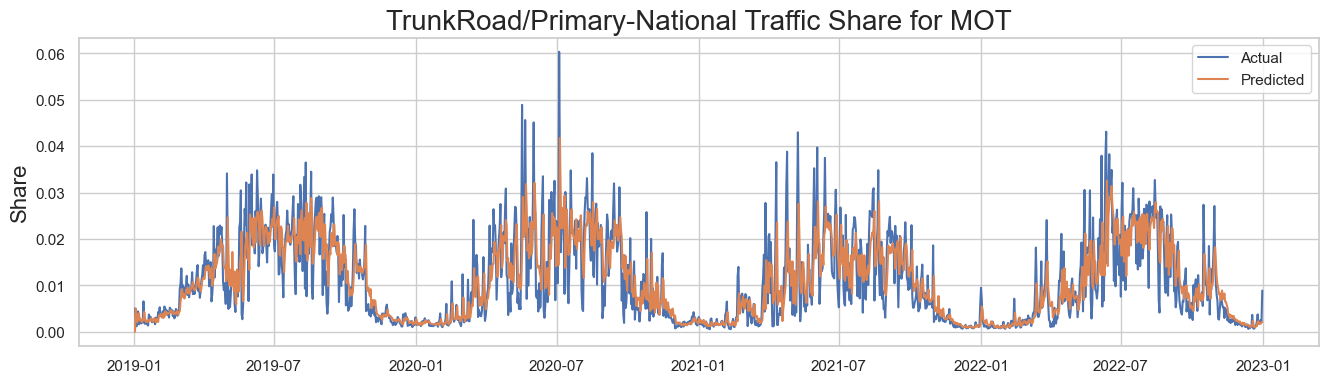

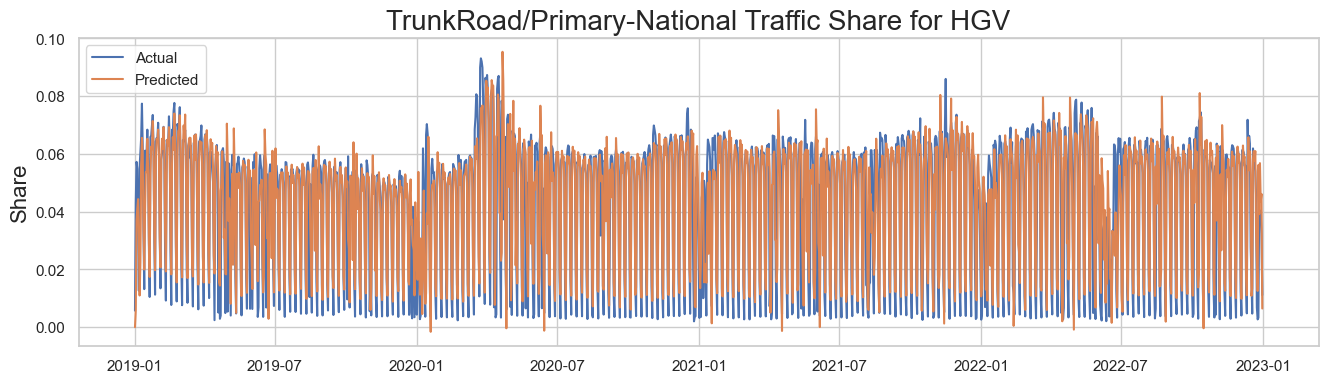

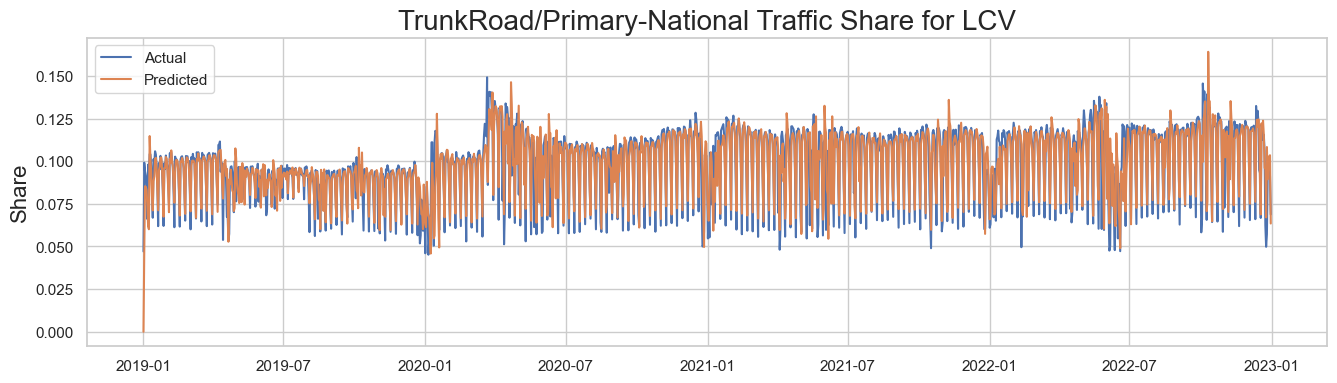

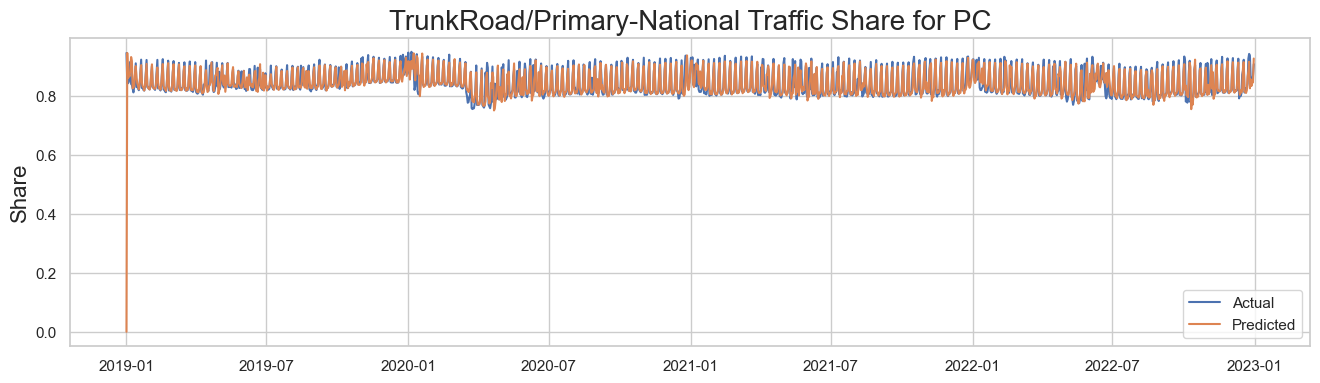

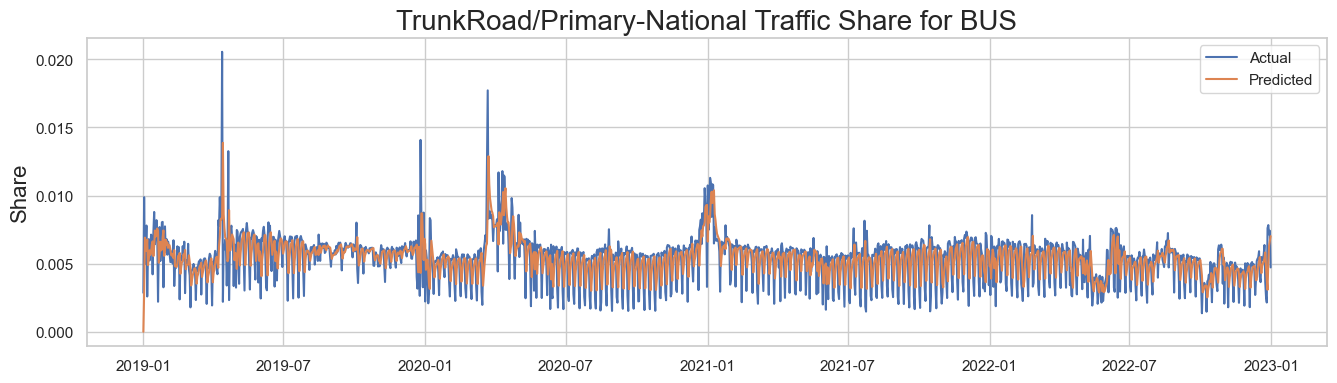

In [34]:

for road_type in vehicle_share_counts['road_type'].unique():
    for vehicle_class in vehicle_share_counts['vehicle_class'].unique():
        print(road_type + ':   ' + vehicle_class)
        train_set = merged_df[(merged_df['road_type'] == road_type) & (merged_df['vehicle_class'] == vehicle_class)][['date', 0]]
        first_non_nan = train_set[0].first_valid_index()
        train_set = train_set.loc[first_non_nan:]
        train_set['date'] = pd.to_datetime(train_set['date'])
        train_set.set_index('date', inplace=True)
        train_set = train_set.asfreq(pd.infer_freq(train_set.index))

        arima = ARIMA(train_set[0], order=(12,1,1))
        predictions = arima.fit().predict()

        train_set[0][np.isnan(train_set[0])] = predictions[np.isnan(train_set[0])]



        plt.figure(figsize=(16,4))
        plt.plot(train_set, label="Actual")
        plt.plot(predictions, label="Predicted")
        plt.title(road_type + ' Traffic Share for ' + vehicle_class, fontsize=20)
        plt.ylabel('Share', fontsize=16)
        plt.legend()


In [80]:
file_path = data_paths.COUNTING_PATH + 'counting_data_combined.parquet'
counting_df = pd.read_parquet(file_path)

In [99]:
aggregeted_counting_df = counting_df.groupby(['road_type','vehicle_class','date']).sum().reset_index()
aggregeted_counting_df.to_csv('agg_counting_data.csv')

In [100]:
counting_df.columns

Index(['road_link_id', 'vehicle_class', 'date', 'daily_value', 'road_type', 'complete', 'day_type', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'], dtype='object')

In [103]:
limited_counting_df = counting_df[['road_link_id', 'vehicle_class', 'date', 'daily_value']]

In [120]:
train_set = limited_counting_df[(limited_counting_df['road_link_id'] == 3.80000000e+01) & (limited_counting_df['vehicle_class'] == 'SUM')][['date','daily_value']]
train_set['date'] = pd.to_datetime(train_set['date'])
train_set.set_index('date', inplace=True)
train_set = train_set.asfreq(pd.infer_freq(train_set.index))

Text(0, 0.5, 'Volume')

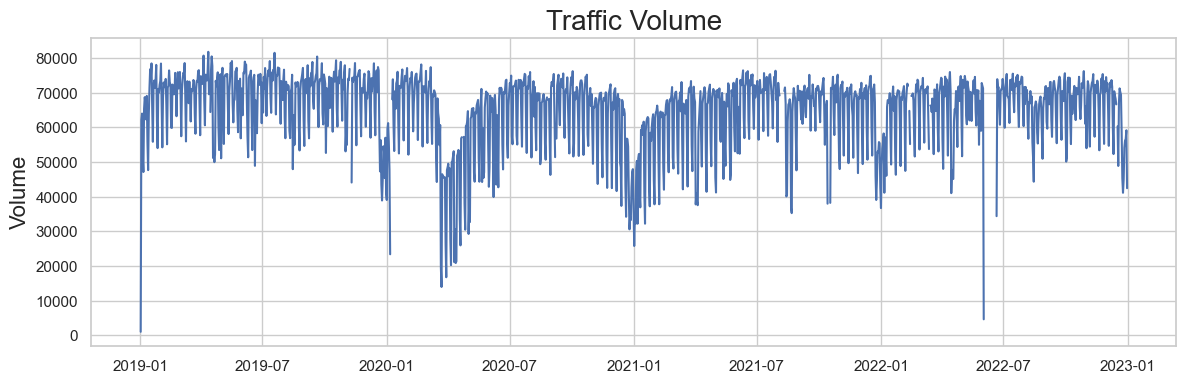

In [122]:
#plot
plt.figure(figsize=(14,4))
plt.plot(train_set)
plt.title('Traffic Volume', fontsize=20)
plt.ylabel('Volume', fontsize=16)

In [126]:
arima = ARIMA(train_set['daily_value'], order=(12,1,1))
predictions = arima.fit().predict()

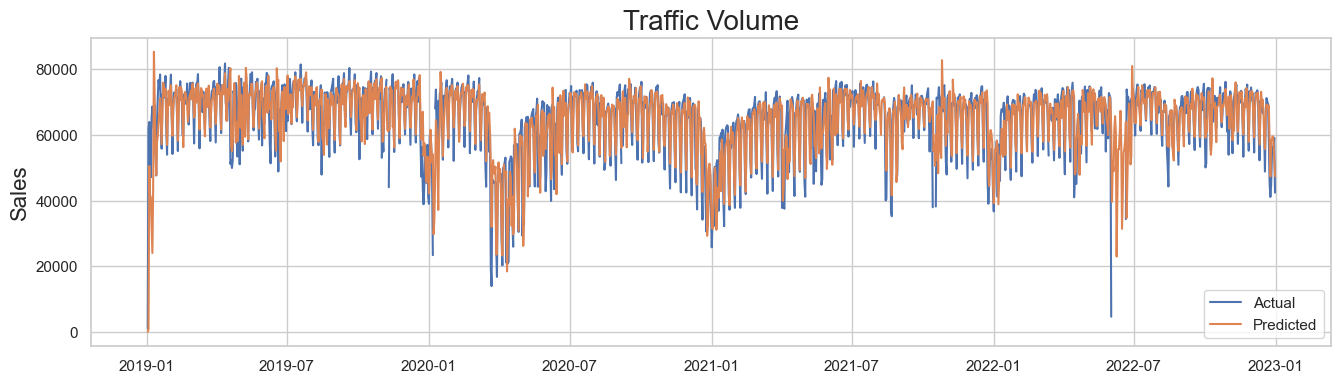

In [130]:
plt.figure(figsize=(16,4))
plt.plot(train_set, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Traffic Volume', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()